# Forming networks from co-occurence of genes in papers

This notebook takes data obtained from pubmed, like in Obtaining_PubMed_data.ipynb. It uses sciscpacy's biological language model (plus some custom post-processing) to identify genes. Then, proximity in the paper is used to construct a network of gene associations.

In [1]:
import os
import pandas as pd
import numpy as np
import scispacy
import spacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
# Clean text of the paper bodies are store in papers/ for a small selection of papers.
allpapers = os.listdir('papers')
all_papers = []
for p in allpapers:
    with open('papers/'+p, 'r') as f:
        all_papers.append(f.read())
        


In [3]:
nlp = spacy.load("en_ner_bionlp13cg_md")

In [4]:
docs = [nlp(text) for text in all_papers]

In [5]:
genes = []
positions = []
for ent in docs[2].ents:
    if len(ent.text) > 2 and 'GENE' in ent.label_ and ent.text.isupper():
        # print(f"{ent.text:20s}, {ent.start_char:6}, {ent.end_char:6}, {ent.label_:20s}")
        genes.append(ent.text.strip().replace('.', ''))
        positions.append(ent.start_char)

(81, 3)


<AxesSubplot:>

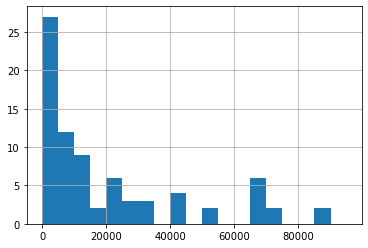

In [6]:
# Calculate distances
pos1 = np.array(positions)
pos2 = pos1.reshape(-1, 1)
dists = abs((pos1-pos2).astype(float))
# Set diagonal to inf
i = np.arange(len(pos1))
dists[i,i] = np.inf
# Make DataFrame
dist_df = pd.DataFrame(dists, columns=genes, index=genes).reset_index().rename(columns={'index':'Gene'})
# Long form
distances = dist_df.melt(id_vars=['Gene'], value_vars=genes, var_name='Gene2', value_name='distance')
combinations = (distances.groupby(['Gene', 'Gene2']).distance.min()).reset_index()
print(combinations.shape)
combinations.distance.hist(bins=np.arange(0,100000,5000))


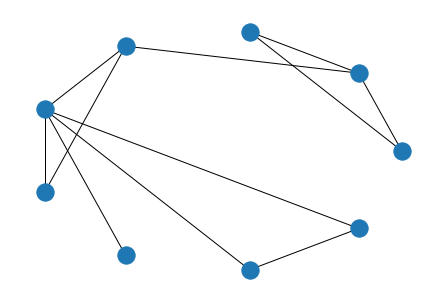

In [7]:
# Select "small" distances
distlim = 5000
assoc = combinations[combinations.distance < distlim]
# Build network of combinations with small distances
G = nx.Graph()
for ir, row in assoc.iterrows():
    if row.Gene == row.Gene2: continue
    G.add_edge(row.Gene, row.Gene2)

nx.draw(G, pos=nx.circular_layout(G))

In [8]:
G